In [1]:
#Import Packages
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:

#Upload Data and Indexing with Time

df = pd.read_csv("Electric_Production.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

df = df.set_index('DATE')

df = df['2014-01-01':'2016-12-29'].resample('W').sum()
df.head()

,IPG2211A2N
DATE,
2014-01-05,124.2549
2014-01-12,0.0000
2014-01-19,0.0000
2014-01-26,0.0000
2014-02-02,112.8811


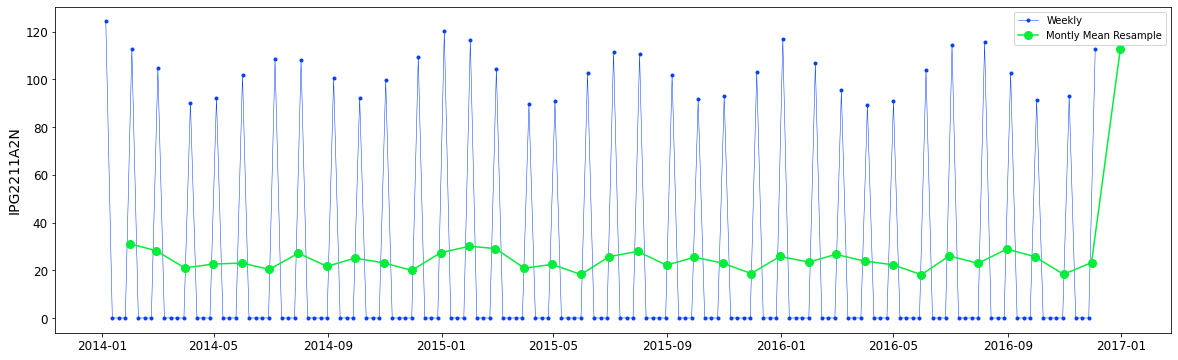

In [3]:
#Visulization the data

y= df['IPG2211A2N']
fig, ax =plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.',linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Montly Mean Resample')
ax.set_ylabel('IPG2211A2N')
ax.legend();

In [4]:
#Decomposing the Data

def seasonal_decompose(y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

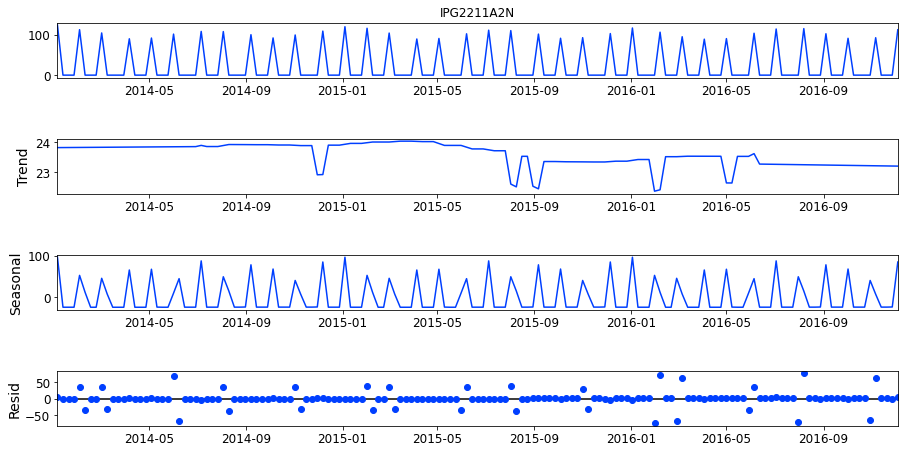

In [5]:
seasonal_decompose(y)

In [6]:
#Checking Stationarity
#Visualization: Graphing the rolling statistics

def test_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

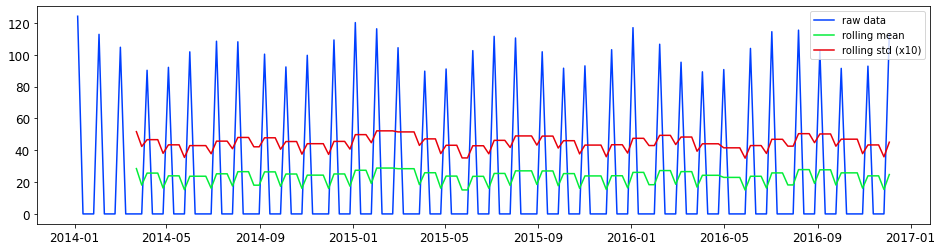

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y, 'raw data')

In [8]:
#Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > IS the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [9]:
ADF_test(y, 'raw data')

 > IS the raw data stationary ?
Test statistic = -5.578
P-value = 0.000
Critical values :
	1%: -3.4776006742422374 - The data is  stationary with 99% confidence
	5%: -2.882265832283648 - The data is  stationary with 95% confidence
	10%: -2.5778219289774156 - The data is  stationary with 90% confidence


 > IS the de-trended data stationary ?
Test statistic = -5.636
P-value = 0.000
Critical values :
	1%: -3.4816817173418295 - The data is  stationary with 99% confidence
	5%: -2.8840418343195267 - The data is  stationary with 95% confidence
	10%: -2.578770059171598 - The data is  stationary with 90% confidence


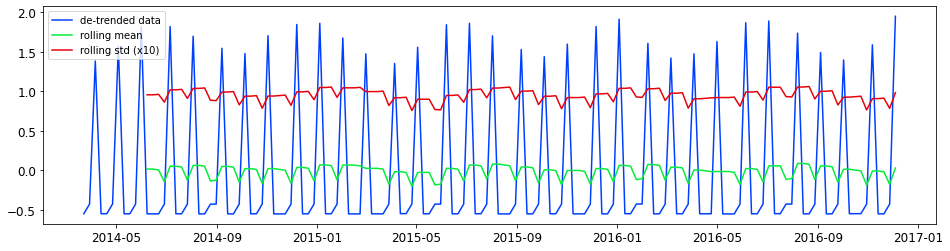

In [10]:
#Detrending

y_detrend = (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend, 'de-trended data')
ADF_test(y_detrend, 'de-trended data')

 > IS the 12 lag differenced data stationary ?
Test statistic = -5.517
P-value = 0.000
Critical values :
	1%: -3.4833462346078936 - The data is  stationary with 99% confidence
	5%: -2.8847655969877666 - The data is  stationary with 95% confidence
	10%: -2.5791564575459813 - The data is  stationary with 90% confidence


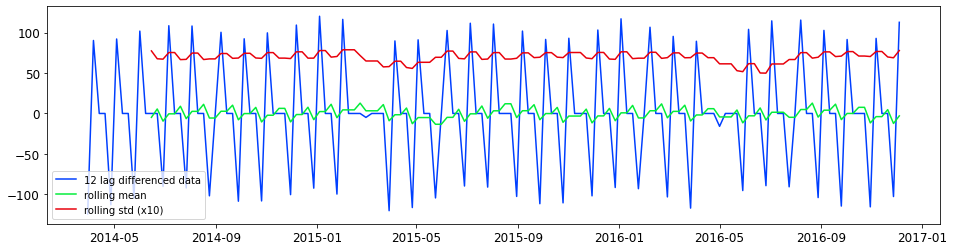

In [11]:
#Differencing

y_12lag = y - y.shift(12)
test_stationarity(y_12lag, '12 lag differenced data')
ADF_test(y_12lag, '12 lag differenced data')

 > IS the 12 lag differenced de-trended data stationary ?
Test statistic = -3.868
P-value = 0.002
Critical values :
	1%: -3.4880216384691867 - The data is  stationary with 99% confidence
	5%: -2.8867966864160075 - The data is  stationary with 95% confidence
	10%: -2.5802408234244947 - The data is  stationary with 90% confidence


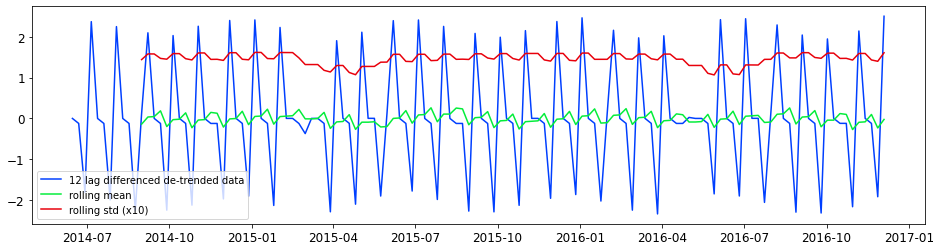

In [12]:
# Detrending + Differencing

y_12lag_detrend = y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend, '12 lag differenced de-trended data')
ADF_test(y_12lag_detrend, '12 lag differenced de-trended data')

In [13]:
# Set the y_to_train, y_to_test, and the length of predict units
y_to_train = y[:'2016-05-26'] #dataset to train
y_to_val = y['2016-06-02':] #last x months for test
predict_date = len(y) - len(y[:'2016-06-02']) #the number of data points for the test set

In [14]:
len(y)

153

In [15]:
# Simple Exponential Smoothing

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o',color='black', legend=True, figsize=(14,7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    
    #specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o', color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forcasts with smoothing level of {} is {}'.format(smoothing_level, round(np.sqrt(mse1), 2)))
    
    #auto optimization 
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    
    #plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forcasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()


The Root Mean Squared Error of our forcasts with smoothing level of 0.8 is 49.67
The Root Mean Squared Error of our forcasts with auto optimization is 44.18


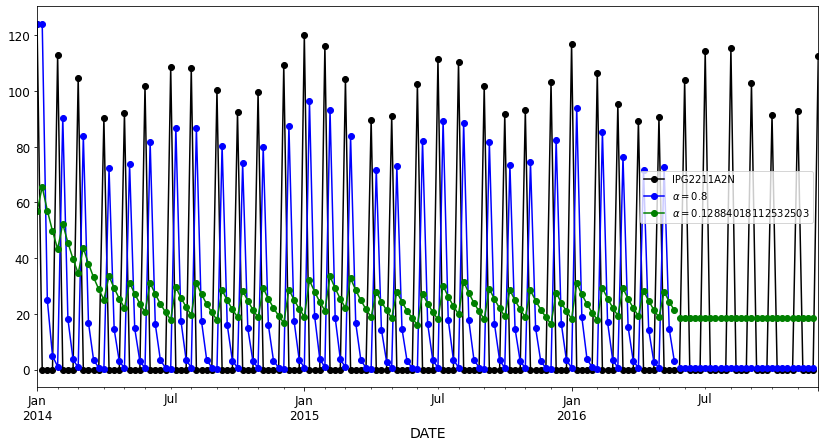

In [16]:
ses(y, y_to_train, y_to_val,0.8,predict_date)